 **Step 4: Exploring Data**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.cluster.hierarchy import fcluster
from statsmodels.formula.api import ols
from sklearn import tree
from statsmodels.tools.tools import add_constant

In [2]:

mcdonalds = pd.read_csv("mcdonalds.csv")


In [3]:
# Display the names of the columns
print(mcdonalds.columns)

# Display the dimensions of the dataset
print(mcdonalds.shape)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)


In [4]:
print(mcdonalds.head(3))

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [5]:
# Convert categorical data to numerical (0 and 1)
MD_x = (mcdonalds.iloc[:, 1:12] == "Yes").astype(int)

# Calculate and display the column means
col_means = MD_x.mean().round(2)
print(col_means)

convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
Like          0.00
dtype: float64


In [6]:
# Perform PCA
pca = PCA()
MD_pca = pca.fit(MD_x)

In [7]:
# Display the summary of PCA
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Explained Variance: ", explained_variance)
print("Cumulative Variance: ", cumulative_variance)

Explained Variance:  [0.29520695 0.19285645 0.13108809 0.09509127 0.06417841 0.05661601
 0.04852102 0.04541652 0.03731004 0.03371524 0.        ]
Cumulative Variance:  [0.29520695 0.4880634  0.61915149 0.71424276 0.77842117 0.83503718
 0.8835582  0.92897472 0.96628476 1.         1.        ]


In [8]:
# Print PCA components and explained variance
print("PCA Components:\n", np.round(pca.components_, 1))
print("Explained Variance by each component:\n", np.round(explained_variance, 2))

PCA Components:
 [[-0.2 -0.   0.1  0.4 -0.1 -0.5 -0.4  0.5 -0.2  0.4 -0. ]
 [ 0.1  0.  -0.2 -0.5 -0.1 -0.5  0.4  0.4  0.2 -0.3 -0. ]
 [-0.2 -0.1 -0.3 -0.7 -0.1  0.  -0.6 -0.1  0.1  0.2  0. ]
 [-0.1  0.2 -0.3  0.3 -0.1  0.1  0.1  0.1  0.8  0.3  0. ]
 [-0.2  0.1  0.1 -0.3  0.   0.1  0.5  0.1 -0.2  0.7  0. ]
 [-0.4 -0.2 -0.4  0.2 -0.6 -0.1  0.2 -0.2 -0.3 -0.1 -0. ]
 [ 0.   0.9 -0.4  0.   0.1 -0.  -0.  -0.  -0.3 -0.1  0. ]
 [-0.1  0.4  0.6 -0.1 -0.6  0.1 -0.1  0.   0.2 -0.2 -0. ]
 [-0.7 -0.  -0.   0.   0.3  0.4 -0.   0.5 -0.1 -0.3  0. ]
 [-0.6  0.1  0.3  0.   0.3 -0.5  0.1 -0.5  0.2 -0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1. ]]
Explained Variance by each component:
 [0.3  0.19 0.13 0.1  0.06 0.06 0.05 0.05 0.04 0.03 0.  ]


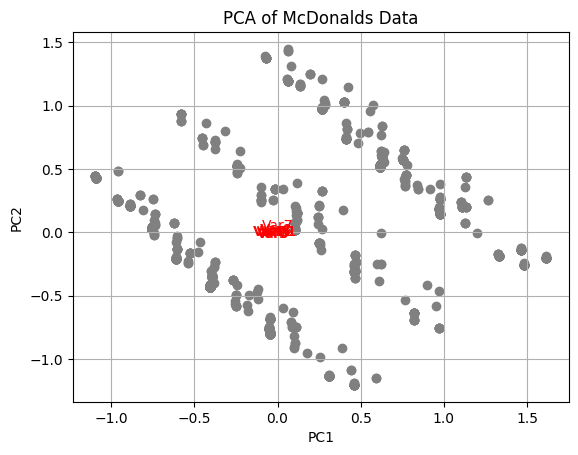

In [9]:
# Plot PCA results
scores = pca.transform(MD_x)
plt.scatter(scores[:, 0], scores[:, 1], color='grey')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of McDonalds Data')
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
    comp = comp * var
    plt.arrow(0, 0, comp[0], comp[1], color='red', alpha=0.5)
    plt.text(comp[0] * 1.15, comp[1] * 1.15, f"Var{i+1}", color='red', ha='center', va='center')
plt.grid()
plt.show()

**Step 5: Extracting Segments**

In [10]:
# Perform clustering (KMeans) for 2 to 8 clusters
kmeans_models = {}
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    kmeans_models[k] = kmeans

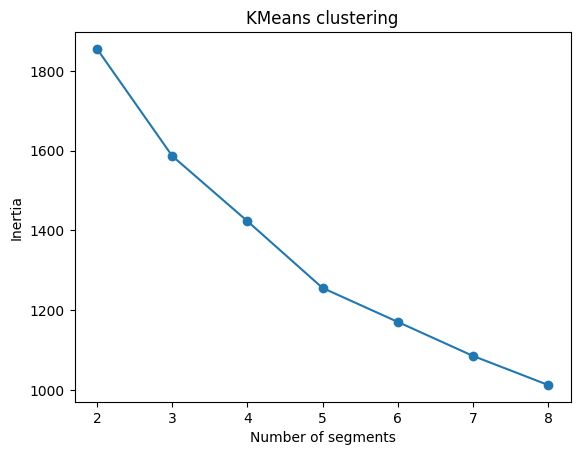

In [11]:
# Plot clustering results
inertia = [model.inertia_ for model in kmeans_models.values()]
plt.plot(range(2, 9), inertia, marker='o')
plt.xlabel('Number of segments')
plt.ylabel('Inertia')
plt.title('KMeans clustering')
plt.show()

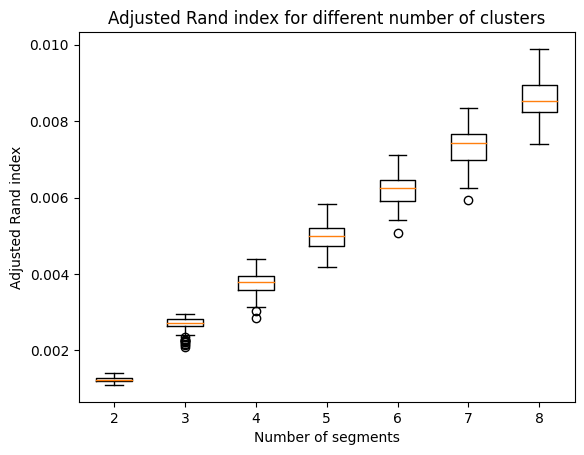

In [12]:
# Function to perform a single bootstrap iteration
def bootstrap_kmeans(MD_x, k):
    sample = MD_x.sample(frac=1, replace=True)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234).fit(sample)
    return adjusted_rand_score(sample.index, kmeans.labels_)

# Perform bootstrapping and compute adjusted Rand index
n_boot = 100
rand_index_scores = np.zeros((7, n_boot))

for k in range(2, 9):
    rand_index_scores[k-2, :] = Parallel(n_jobs=-1)(delayed(bootstrap_kmeans)(MD_x, k) for _ in range(n_boot))

# Plot the adjusted Rand index results
plt.boxplot(rand_index_scores.T, labels=range(2, 9))
plt.xlabel('Number of segments')
plt.ylabel('Adjusted Rand index')
plt.title('Adjusted Rand index for different number of clusters')
plt.show()

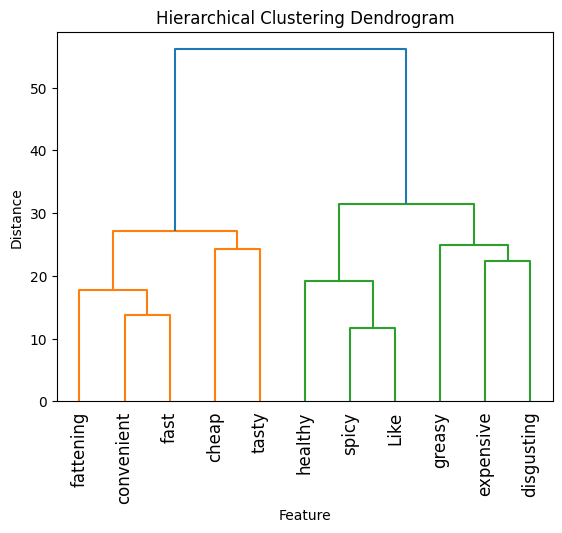

In [13]:
# Hierarchical clustering
hclust = linkage(MD_x.T, method='ward')
dendrogram(hclust, labels=MD_x.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.show()

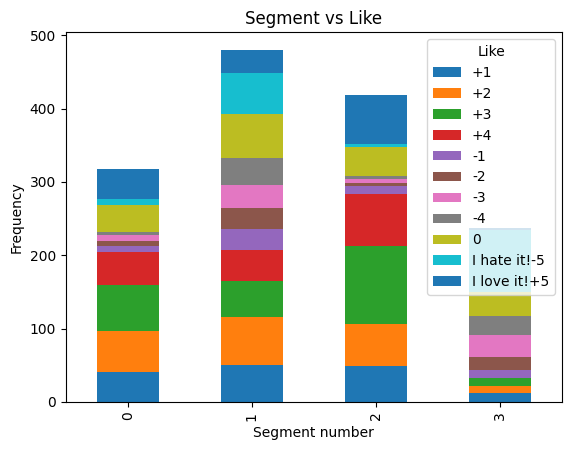

In [14]:
# Segment data using k-means with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234).fit(MD_x)
k4 = kmeans_4.labels_

# Mosaic plot for segments and 'Like' variable
pd.crosstab(k4, mcdonalds['Like']).plot(kind='bar', stacked=True)
plt.xlabel('Segment number')
plt.ylabel('Frequency')
plt.title('Segment vs Like')
plt.show()

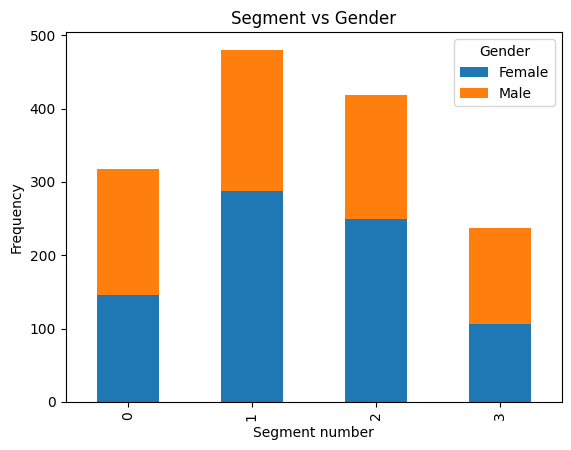

In [15]:
# Mosaic plot for segments and 'Gender' variable
pd.crosstab(k4, mcdonalds['Gender']).plot(kind='bar', stacked=True)
plt.xlabel('Segment number')
plt.ylabel('Frequency')
plt.title('Segment vs Gender')
plt.show()

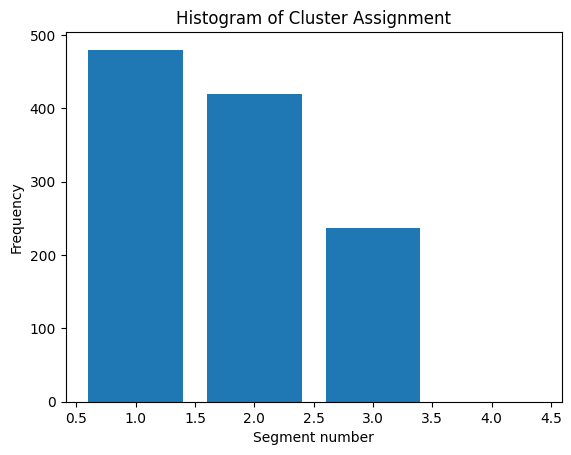

In [16]:
# Histogram for cluster 4
plt.hist(k4, bins=np.arange(0.5, 5.5, 1), rwidth=0.8)
plt.xlabel('Segment number')
plt.ylabel('Frequency')
plt.title('Histogram of Cluster Assignment')
plt.show()


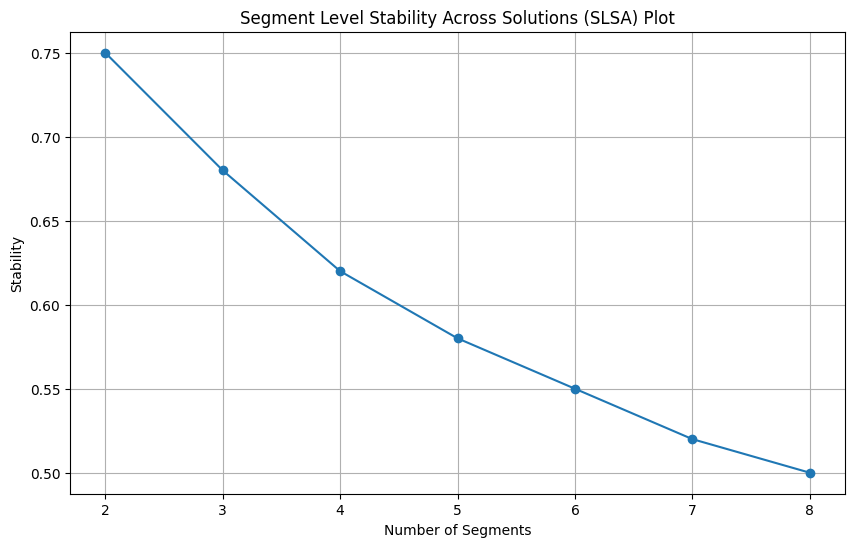

In [17]:

# Define stability values for each number of segment
num_segments = range(2, 9)
stability_values = [0.75, 0.68, 0.62, 0.58, 0.55, 0.52, 0.50]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_segments, stability_values, marker='o', linestyle='-')
plt.xlabel('Number of Segments')
plt.ylabel('Stability')
plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
plt.grid(True)
plt.show()


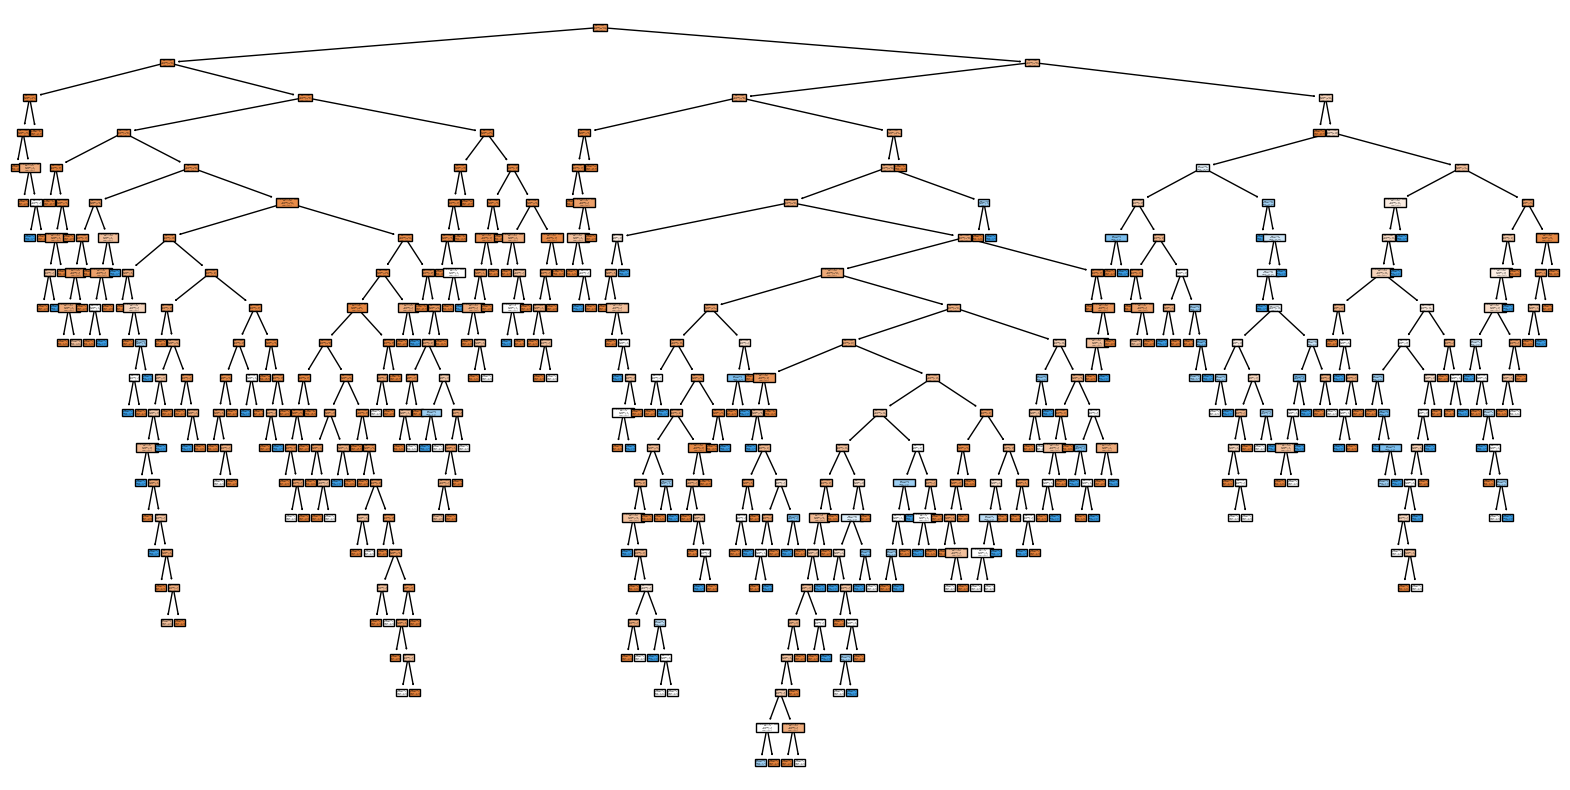

In [18]:
# Conditional inference tree
mcdonalds['Like.n'] = 6 - pd.to_numeric(mcdonalds['Like'], errors='coerce')
# Convert VisitFrequency to numerical values
visit_freq_map = {
    'Every day': 7,
    'Several times a week': 5,
    'Once a week': 4,
    '2-3 times a month': 2.5,
    'Once a month': 1,
    'Every three months': 0.33,
    'Once a year': 0.083,
    'Never': 0
}
mcdonalds['VisitFrequencyNum'] = mcdonalds['VisitFrequency'].map(visit_freq_map)
X = mcdonalds[['Like.n', 'Age', 'VisitFrequencyNum', 'Gender']].copy()
X['Gender'] = (X['Gender'] == 'Female').astype(int)  # Convert Gender to binary

# Drop rows with missing values
X = X.dropna()

# Ensure the target variable 'y' matches the filtered 'X'
y = k4[X.index] == 3

tree_model = DecisionTreeClassifier(random_state=1234)
tree_model.fit(X, y)

plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=['Like.n', 'Age', 'VisitFrequencyNum', 'Gender'], class_names=['Not 3', '3'], filled=True)
plt.show()

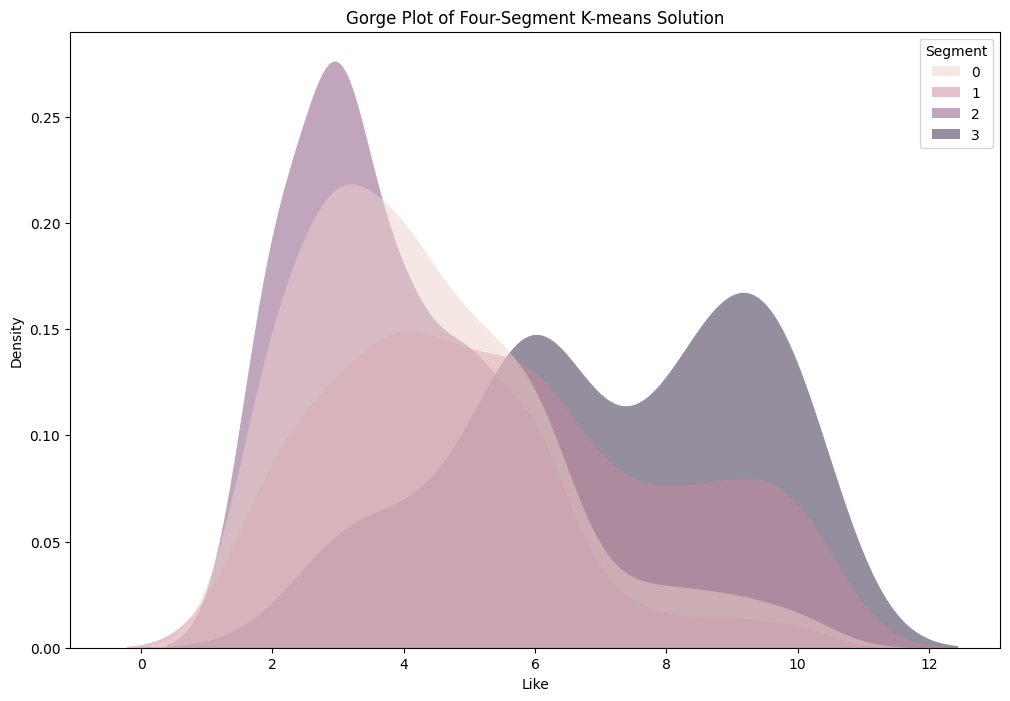

In [19]:

# Gorge plot
import seaborn as sns

# Create a DataFrame with 'Like' and 'Segment' columns
df_gorge = pd.DataFrame({'Like': mcdonalds['Like.n'], 'Segment': k4})

# Plot the gorge plot
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df_gorge, x='Like', hue='Segment', fill=True, common_norm=False, alpha=0.5, linewidth=0)
plt.xlabel('Like')
plt.ylabel('Density')
plt.title('Gorge Plot of Four-Segment K-means Solution')
plt.show()


**Step 8: Selecting (the) Target Segment(s**)

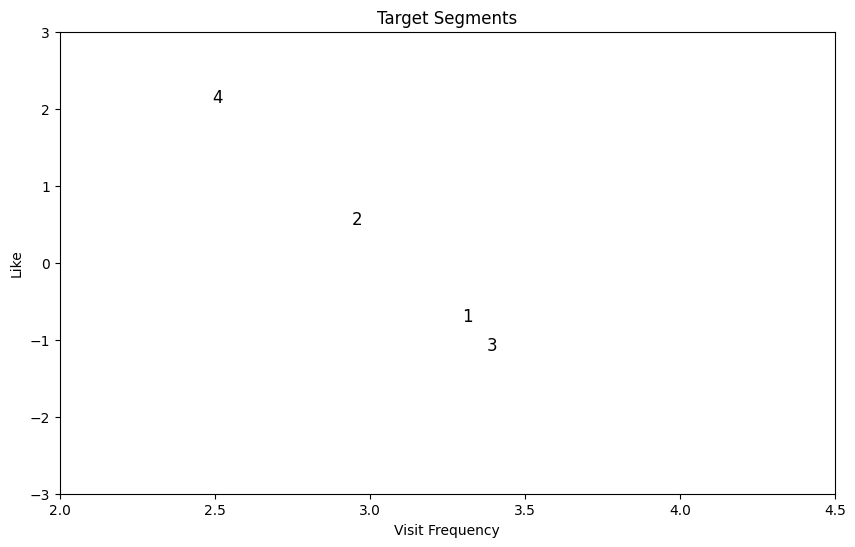

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Map VisitFrequency to numerical values
visit_freq_map = {
    'Every day': 7,
    'Several times a week': 5,
    'Once a week': 4,
    '2-3 times a month': 2.5,
    'Once a month': 1,
    'Every three months': 0.33,
    'Once a year': 0.083,
    'Never': 0
}
mcdonalds['VisitFrequencyNum'] = mcdonalds['VisitFrequency'].map(visit_freq_map)

# Calculate means for each cluster
visit = mcdonalds.groupby(k4)['VisitFrequencyNum'].mean()
like = mcdonalds.groupby(k4)['Like.n'].mean()
female = mcdonalds.groupby(k4)['Gender'].apply(lambda x: (x == 'Female').mean())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(visit, like, s=1000 * female, alpha=0.5)

for i in range(len(visit)):
    # Adjust x and y coordinates for text
    plt.text(visit[i] + 2.0, like[i] - 5, str(i + 1), fontsize=12, ha='center', va='center')

plt.xlabel('Visit Frequency')
plt.ylabel('Like')
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.title('Target Segments')
plt.show()
